For the full project, visit the [GitHub repository](https://github.com/TugdualKerjan/Audio-VQVAE-for-JAX).

# Context 👀

I'm trying to rewrite XTTS in JAX to understand how it works. 

We are going to implement the VQVAE used in [@casanova2024xttsmassivelymultilingualzeroshot], a Text to Speech model written by the defunct Coqai company. VQVAEs come from [@oord2018neuraldiscreterepresentationlearning]

VQVAE means Vector Quantized Variational AutoEncoder. Let's break down the name. 

__Auto-Encoder__

This model takes the input, passes it through smaller layers (Encodes) and tries to, from that small layer, reproduce the input (Decodes). It thus needs to learn what are the most important features to keep ! If the input was images of cats, the model would keep information about the color, way it's looking, thiccness of the cat.

__Variational__

Instead of having to encode inputs onto points in space we map them onto distributions. In our case, we simply want to make sure that on average, the space we're mapping to is uniform. This means all _codes_ will be used.

__Vector Quantized__

We want to define a set of points in the smaller representation, the latent. These points will be called _codes_ and be part of a _codebook_. Think of the codebook as the set of possible words the encoder can use to describe what it sees to the decoder. Obviously, the more codes we have, the more information the encoder will be able to pass per code sent.

![Overview of the model [@csdn_image_2024]](assets/vqvae.png)

# Goal 🎯

Our VQVAE is going to find the best codes that describe speech. It'll take in special images called Mel-Frequency Spectrograms, which is basically a way to represent human speech.

Since our final goal is to recreate a 1 to 1 version of the VQVAE used in XTTS, we'll hardcode a lot of things to minimize issues.



In [ ]:
#| code-fold: true

DiscreteVAE(
  (discrete_loss): DiscretizationLoss()
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(80, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (2): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (4): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (5): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
    (1): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (2): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (4): Sequential(
      (0): UpsampledConv(
        (conv): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
    )
    (5): Sequential(
      (0): UpsampledConv(
        (conv): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
    )
    (6): Conv1d(512, 80, kernel_size=(1,), stride=(1,))
  )
  (codebook): Quantize()
)

# Model

We have 4 parts to code: An ResBlock, Encoder, a Decoder and a Quantizer. Let's get into it!

Importing JAX and Equinox, a library that helps with writing neural networks.

In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import typing as tp

## ResBlocks

The role of this Block is to mainly exchange information between the various parts of each channel, but the input is added at the end. This allows our network to basically, if suitable, simply put all weights to zero and be "Shallower" basically our network decides how many layers it needs !

In [ ]:
class ResBlock(eqx.Module):
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    act: tp.Callable = eqx.static_field()

    def __init__(self, dim: int, activation=jax.nn.relu, key=None):

        key1, key2, key3 = jax.random.split(key, 3)

        self.conv1 = nn.Conv1d(dim, dim, kernel_size=3, padding="SAME", key=key1)
        self.conv2 = nn.Conv1d(dim, dim, kernel_size=3, padding="SAME", key=key2)
        self.conv3 = nn.Conv1d(dim, dim, kernel_size=1, padding="SAME", key=key3)

        self.act = activation

    def __call__(self, x):
        y = x

        y = self.conv1(y)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)

        y = y + x

        return y

## Encoder

Moving onto the Encoder. It has layers that take in the input, and slowly compress it by lowering the image dimensions and increasing the amounts of channels, much like ResNet:

::: {#fig-encode}

![Visualisation of what the encoder is doing [@dumakude2023automated_image]](assets/encode.png)

:::


In [ ]:
class Encoder(eqx.Module):
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    res1: ResBlock
    res2: ResBlock
    res3: ResBlock

    def __init__(self, hidden_dim: int = 1024, codebook_dim: int = 512, key=None):
        key1, key2, key3, key4, key5, key6 = jax.random.split(key, 6)

        self.conv1 = nn.Conv1d(
            in_channels=80,
            out_channels=512,
            kernel_size=3,
            stride=2,
            padding="SAME",
            key=key1,
        )
        self.conv2 = nn.Conv1d(
            in_channels=512,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=2,
            padding="SAME",
            key=key2,
        )
        self.res1 = ResBlock(dim=hidden_dim, key=key3)
        self.res2 = ResBlock(dim=hidden_dim, key=key4)
        self.res3 = ResBlock(dim=hidden_dim, key=key5)
        self.conv3 = nn.Conv1d(
            in_channels=hidden_dim,
            out_channels=codebook_dim,
            kernel_size=1,
            stride=1,
            padding="SAME",
            key=key6,
        )

    def __call__(self, x):

        y = self.conv1(x)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.conv3(y)

        return y

## Decoder

We can now implement the decoder. Instead of using ConvTranspose1d here XTTS uses upsampling and interpolation between points, replacing the striding that would usually happen. We implement it just below @sec-plot

In [ ]:
class Decoder(eqx.Module):
    conv1: nn.Conv1d
    conv2: UpsampledConv
    conv3: UpsampledConv
    conv4: nn.Conv1d
    res1: ResBlock
    res2: ResBlock
    res3: ResBlock

    def __init__(self, hidden_dim: int = 1024, codebook_dim: int = 512, key=None):
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)

        self.conv1 = nn.Conv1d(
            in_channels=codebook_dim,
            out_channels=hidden_dim,
            kernel_size=1,
            stride=1,
            padding="SAME",
            key=key1,
        )
        self.res1 = ResBlock(dim=hidden_dim, key=key2)
        self.res2 = ResBlock(dim=hidden_dim, key=key3)
        self.res3 = ResBlock(dim=hidden_dim, key=key4)
        self.conv2 = UpsampledConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=2,
            padding="SAME",
            key=key5,
        )
        self.conv3 = UpsampledConv(
            in_channels=hidden_dim,
            out_channels=512,
            kernel_size=3,
            stride=2,
            padding="SAME",
            key=key6,
        )
        self.conv4 = nn.Conv1d(
            in_channels=512,
            out_channels=80,
            kernel_size=1,
            stride=1,
            padding="SAME",
            key=key7,
        )

    def __call__(self, x):

        y = self.conv1(x)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)
        y = jax.nn.relu(y)
        y = self.conv4(y)

        return y

### UpsampledConv {#sec-plot}

Before we move onto the decoder we have to define a special layer that replaces the ConvTranspose that we would normally use. I admit I still am not sure of the use of this.

Their code for this function:

```python
class UpsampledConv(nn.Module):
    def __init__(self, conv, *args, **kwargs):
        super().__init__()
        assert "stride" in kwargs.keys()
        self.stride = kwargs["stride"]
        del kwargs["stride"]
        self.conv = conv(*args, **kwargs)

    def forward(self, x):
        up = nn.functional.interpolate(x, scale_factor=self.stride, mode="nearest")
        return self.conv(up)
```

We can execute the torch version to check how it works and then compare to our solution

In [ ]:
# | code-fold: true

import torch
import numpy


class UpsampledConv(torch.nn.Module):
    def __init__(self, conv, *args, **kwargs):
        super().__init__()
        assert "stride" in kwargs.keys()
        self.stride = kwargs["stride"]
        del kwargs["stride"]
        self.conv = conv(*args, **kwargs)

    def forward(self, x):
        up = torch.nn.functional.interpolate(
            x, scale_factor=self.stride, mode="nearest"
        )
        print(up.shape)
        return self.conv(up)


upsamp = UpsampledConv(torch.nn.Conv1d, 80, 512, 3, stride=2, padding=1)
x = torch.ones((3, 80, 100))
print(upsamp(x).shape)

We can then write our own version using JAX.

In [ ]:
# | label: upsample


class UpsampledConv(eqx.Module):
    conv: nn.Conv1d
    stride: int = eqx.static_field()

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: tp.Union[int, tp.Tuple[int]],
        stride: int,
        padding: tp.Union[int, str],
        key=None,
    ):
        super().__init__()
        self.stride = stride
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=padding,
            key=key,
        )

    def __call__(self, x):
        upsampled_size = (x.shape[0], x.shape[1] * self.stride)
        upsampled = jax.image.resize(x, upsampled_size, method="nearest")
        return self.conv(upsampled)

Running the code below allows to do a quick check to see it works well

In [ ]:
# | code-fold: true
key = jax.random.PRNGKey(1)
upsamp = UpsampledConv(80, 150, kernel_size=3, stride=2, padding="SAME", key=key)
x = jax.random.normal(key, shape=(80, 100))
y = upsamp(x)
print(x.shape)
print(y.shape)

After having implemented various VQVAEs, what strikes me in this one is that the ResBlocks are all seperated from the various convolutional stages, and the lack of normalisation between layers. Moving onto the crux of the matter, the Quantizer !

## Quantizer

So our encoder spits out a certain number of vectors (The number of channels) with the codebook dim. These vectors are mapped to their nearest neighbors, and these are then transmitted to the decoder. To stabalise the model, we're going to also add some exponential moving average to the codebook, as well as normalize things so as to keep things from exploding or minimizing. Exponential moving average meaning that we basically mostly keep what we currently have and add a little of the new stuff instead of fully changing things every time.

$${Codebook} = {Codebook}_{old} * decay + {Codebook}_{new} * (1 - decay)$$

We can't update the codebook here though, as this is immutable stuff. We need to update it between each training instead.

In [ ]:
# | output: true


class Quantizer(eqx.Module):
    K: int = eqx.static_field()
    D: int = eqx.static_field()
    codebook: jax.Array

    codebook_avg: jax.Array
    cluster_size: jax.Array

    decay: float = eqx.static_field()
    eps: float = eqx.static_field()

    def __init__(
        self,
        num_vecs: int = 1024,
        num_dims: int = 512,
        decay: float = 0.99,
        eps: float = 1e-5,
        key=None,
    ):
        self.K = num_vecs
        self.D = num_dims

        self.decay = decay
        self.eps = eps

        # Init a matrix of vectors that will move with time
        self.codebook = jax.nn.initializers.variance_scaling(
            scale=1.0, mode="fan_in", distribution="uniform"
        )(key, (num_vecs, num_dims))
        self.codebook_avg = jnp.copy(self.codebook)
        self.cluster_size = jnp.zeros(num_vecs)

    def __call__(self, x):
        # x has N vectors of the codebook dimension. We calculate the nearest neighbors and output those instead

        flatten = jax.numpy.reshape(x, (-1, self.D))
        a_squared = jnp.sum(flatten**2, axis=-1, keepdims=True)
        b_squared = jnp.transpose(jnp.sum(self.codebook**2, axis=-1, keepdims=True))
        distance = (
            a_squared
            + b_squared
            - 2 * jnp.matmul(flatten, jnp.transpose(self.codebook))
        )

        codebook_indices = jnp.argmin(distance, axis=-1)

        z_q = self.codebook[codebook_indices]

        # Straight-through estimator
        z_q = flatten + jax.lax.stop_gradient(z_q - flatten)
        
        z_q = jax.numpy.reshape(z_q, (-1, x.shape[-1]))

        return z_q, self.codebook_updates(flatten, codebook_indices)

    def codebook_updates(self, flatten, codebook_indices):

        # Calculate the usage of various codes.
        codebook_onehot = jax.nn.one_hot(codebook_indices, self.K)
        codebook_onehot_sum = jnp.sum(codebook_onehot, axis=0)
        codebook_sum = jnp.dot(flatten.T, codebook_onehot)
        # We've just weighed the codebook vectors.

        # Basically count on average how many codes we're using
        new_cluster_size = (
            self.decay * self.cluster_size + (1 - self.decay) * codebook_onehot_sum
        )

        # Where is the average embedding at ?
        new_codebook_avg = (
            self.decay * self.codebook_avg + (1 - self.decay) * codebook_sum.T
        )

        n = jnp.sum(new_cluster_size)  # Over the total embeddings used
        new_cluster_size = (new_cluster_size + self.eps) / (n + self.K * self.eps) * n
        new_codebook = self.codebook_avg / new_cluster_size[:, None]

        updates = (new_cluster_size, new_codebook_avg, new_codebook)

        return updates, codebook_indices

We can visualize vectors being mapped to the neasest codes below, where light blue vectors come in, and are snapped to the closest red vectors. TODO fix the bug

In [ ]:
# | label: quantized
# | output: true
# | fig-cap: Vectors finding the nearest code
# | column: margin

import matplotlib.pyplot as plt

key = jax.random.PRNGKey(3)

key1, key2 = jax.random.split(key)

quantizer = Quantizer(7, 2, key=key1)
x = jax.random.normal(key2, shape=(2, 2, 3)) / 2

y, _ = jax.vmap(quantizer)(x)

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs = axs.flatten()  # Flatten for easy iteration

# Plot data on each subplot (adjust as needed)
for i, ax in enumerate(axs):
    origin_x = jnp.zeros(3)
    origin_y = jnp.zeros(3)

    # Plot arrows with quiver
    ax.quiver(
        origin_x,
        origin_y,
        y[i, 1, :],
        y[i, 0, :],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="blue",
    )
    ax.quiver(
        origin_x,
        origin_y,
        x[i, 1, :],
        x[i, 0, :],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="blue",
        alpha=0.6,
    )
    ax.quiver(
        jnp.zeros(quantizer.codebook.shape[0]),
        jnp.zeros(quantizer.codebook.shape[0]),
        quantizer.codebook[:, 1],
        quantizer.codebook[:, 0],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="none",
        edgecolor="red",
        linewidth=1.5,
    )
    ax.set_xlim(-0.7, 0.7)  # Adjust limits as needed
    ax.set_ylim(-0.7, 0.7)
    ax.set_aspect("equal")
    ax.set_title(f"Example {i+1}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Show the figure
plt.tight_layout()
plt.show()

What the above does is create K vectors in D dimensional space. Incoming vectors find their nearest match and the loss calculated is the L2 distance.

## VQVAE

Let's finish up by defining a final Module that wraps all of this up, and defining our training.

In [ ]:
class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: Quantizer

    def __init__(self, key=None):
        key1, key2, key3 = jax.random.split(key, 3)

        self.encoder = Encoder(key=key1)
        self.decoder = Decoder(key=key2)
        self.quantizer = Quantizer(decay=0.8, key=key3)

    def __call__(self, x):
        z_e = self.encoder(x)
        z_q, codebook_indices = self.quantizer(z_e)
        y = self.decoder(z_q)

        return z_e, z_q, codebook_indices, y

Let's do a quick test on the full model to make sure that the whole works correctly.



In [ ]:
# | output: true

import jax

key1, key2 = jax.random.split(jax.random.PRNGKey(69))

model = VQVAE(key1)
x = jax.random.normal(key2, shape=(10, 80, 400))
z_e, z_q, _, y = jax.vmap(model)(x)
print(x.shape)
print(z_e.shape)
print(z_q.shape)
print(y.shape)



We can see that we go from a $[80 \times X]$ long spectrogram and go down to a $[512 \times \frac{X}{4}]$ image, which to be fair seems kind of dumb because we actually don't loose any information like this. We could have a 1 to 1 reproduction of the image... was it not for the quantizer in the middle that forces us to assign the image to actually, only $\frac{X}{4}$ vectors ! Whatever the dimension of these vectors, the information we encode can this be counted in $log_2(x/4)$ bits which makes it quite small 🤏😎

# Training

::: {#fig-table .column-margin}

![](assets/chaos.png)

How not to train things

:::

## Codebook special thingies

There are a few things that we need to do. First we need to write a function that will update our model based on the passed ${Codebook}$. It should not only update the various values we're keeping track of, but since we're using a VQVAE and that they impose that the distribution is __uniform__ this means that we need to yeet codes that are being used too often. 

::: {.callout-note}
VAEs work because we impose that they don't just encode important information but they encode it in a uniform way, so that vectors are well spread out and not clustered. Normally you need to add a loss term checking at what point the embeddings follow that spread (usually a guassian distribution). In VQ-VAEs we impose the distribution to be uniform, making this term constant and thus we don't have to add it in the loss
:::

::: {layout-ncol=2}

![With replacing codebook outliers](assets/spread.png){#fig-surus}

![Without replacement](assets/close.png){#fig-hanno}

:::

In [1]:
import optax
import equinox as eqx
import jax.numpy as jnp
from tensorboardX import SummaryWriter


def update_codebook_ema(model, updates: tuple, codebook_indices, key=None):
    avg_updates = jax.tree.map(lambda x: jax.numpy.mean(x, axis=0), updates)

    # Calculate which codes are too often used and yeet them. Prior is uniform.
    h = jnp.histogram(
        codebook_indices, bins=model.quantizer.K, range=(0, model.quantizer.K)
    )[0] / len(codebook_indices)
    part_that_should_be = 1 / model.quantizer.K
    mask = (h > 2 * part_that_should_be) | (h < 0.5 * part_that_should_be)
    rand_embed = (
        jax.random.normal(key, (model.quantizer.K, model.quantizer.D)) * mask[:, None]
    )
    avg_updates = (
        avg_updates[0],
        avg_updates[1],
        jnp.where(mask[:, None], rand_embed, avg_updates[2]),
    )

    where = lambda q: (
        q.quantizer.cluster_size,
        q.quantizer.codebook_avg,
        q.quantizer.codebook,
    )

    # Update the codebook and other trackers.
    model = eqx.tree_at(where, model, avg_updates)
    return model

## Losses and gradients

Nearly there ! 😮‍💨 We can now write out our two "classic" functions, that will 1. Calculate at what point our boi outputs garbage or not, by comparing outputs to inputs using Mean Square Error, and at what point the encoder is outputing vectors that are close to the codes available.

In [3]:

@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    z_e, z_q, codebook_updates, y = jax.vmap(model)(x)

    # Are the inputs and outputs close?
    reconstruct_loss = jnp.mean(jnp.linalg.norm((x - y), ord=2, axis=(1, 2)))

    # Are the output vectors z_e close to the codes z_q ?
    commit_loss = jnp.mean(
        jnp.linalg.norm(z_e - jax.lax.stop_gradient(z_q), ord=2, axis=(1, 2))
    )
    # codebook = jnp.mean(codebook_updates[0][2], axis=0) #| hide_line
    # print(codebook.shape) #| hide_line
    # print(codebook) #| hide_line
    # print(jnp.mean(codebook, axis=-1).shape) #| hide_line
    # print(f"STDR: {jnp.std(codebook, axis=-1)}") #| hide_line
    # print(f"log: {jnp.log(jnp.clip(jnp.mean(codebook, axis=-1), min=1e-5)) }") #| hide_line
    # KL_loss = 0.5 * jnp.sum(jnp.mean(codebook, axis=-1)**2 + jnp.var(codebook, axis=-1)  #| hide_line- jnp.log(jnp.clip(jnp.std(codebook, axis=-1), min=1e-6)) - 1) #| hide_line

    total_loss = reconstruct_loss + commit_loss

    return total_loss, (reconstruct_loss, commit_loss, codebook_updates, y)


@eqx.filter_jit
def make_step(model, optimizer, opt_state, x, key):
    (total_loss, (reconstruct_loss, commit_loss, codebook_updates, y)), grads = (
        calculate_losses(model, x)
    )
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    model = update_codebook_ema(model, codebook_updates[0], codebook_updates[1], key)

    return (
        model,
        opt_state,
        total_loss,
        reconstruct_loss,
        commit_loss,
        codebook_updates,
        y,
    )

In [ ]:
# | echo: false

key = jax.random.PRNGKey(69)

model = VQVAE(key=key)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir="./runs")

for i in range(0, 100):
    x = jnp.ones((10, 80, 100))
    model, opt_state, total_loss, reconstruct_loss, commit_loss, codebook_updates, y = (
        make_step(model, optimizer, opt_state, x)
    )
    print(f"Total loss: {total_loss}")

    # Log codebook updates to TensorBoard
    writer.add_scalar("Loss/Total", total_loss, i)
    writer.add_scalar("Loss/Reconstruct", reconstruct_loss, i)
    writer.add_scalar("Loss/Commit", commit_loss, i)
    # writer.add_histogram('Codebook Updates/Cluster Size', jnp.mean(codebook_updates[0], axis=0), i)
    # writer.add_scalar('Codebook Updates/Codebook Avg', jnp.mean(codebook_updates[1], axis=0), i)
    writer.add_histogram(
        "Codebook Updates/Code ids used", jnp.sum(codebook_updates[1], axis=(0)), i
    )
    writer.add_histogram(
        "Codebook Updates/Code means", jnp.mean(codebook_updates[0][2], axis=(0, 2)), i
    )
    writer.add_histogram(
        "Codebook Updates/Code stds", jnp.std(codebook_updates[0][2], axis=(0, 2)), i
    )

## Preparing the data

Let's download some data and make runs through to see if it can learn from it ! 

XTTS has this function that seems to transform the incoming wav files into nice mel_spectrograms. To optimize the time spent loading the data, we'll transform all the data into input arrays first, and then during the run load from those instead.

In [ ]:
# | code-fold: true
import torchaudio


def dvae_wav_to_mel(
    wav,
    mel_norms_file="../experiments/clips_mel_norms.pth",
    mel_norms=None,
    device=torch.device("cpu"),
):
    mel_stft = torchaudio.transforms.MelSpectrogram(
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        power=2,
        normalized=False,
        sample_rate=22050,
        f_min=0,
        f_max=8000,
        n_mels=80,
        norm="slaney",
    ).to(device)
    wav = wav.to(device)
    mel = mel_stft(wav)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    if mel_norms is None:
        mel_norms = torch.load(mel_norms_file, map_location=device)
    mel = mel / mel_norms.unsqueeze(0).unsqueeze(-1)
    return mel


We'll be using LJSpeech [@ljspeech17] as a dataset because it has just the right amount of samples to get some real training.


In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [ ]:
!tar -xvjf ./LJSpeech-1.1.tar.bz2

In [ ]:
import torchaudio
from pathlib import Path
import librosa
import torch
from tqdm import tqdm
import numpy

sample_rate = 22050


def dvae_wav_to_mel(
    wav, mel_norms_file="./mel_stats.pth", mel_norms=None, device=torch.device("cpu")
):
    mel_stft = torchaudio.transforms.MelSpectrogram(
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        power=2,
        normalized=False,
        sample_rate=22050,
        f_min=0,
        f_max=8000,
        n_mels=80,
        norm="slaney",
    ).to(device)
    wav = wav.to(device)
    mel = mel_stft(wav)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    if mel_norms is None:
        mel_norms = torch.load(mel_norms_file, map_location=device)
    mel = mel / mel_norms.unsqueeze(0).unsqueeze(-1)
    return mel


dataset_dest_path = "dataset/mels"

files = list(Path("./LJSpeech-1.1").rglob("*.wav"))


def boop():
    for file in tqdm(files):
        y, sr = librosa.load(file)
        if sr != sample_rate:
            y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)
        y = torch.from_numpy(y)
        mel = dvae_wav_to_mel(y)

        data = mel.cpu().numpy()
        save_path = Path(dataset_dest_path, f"{file.stem}.npy")
        numpy.save(save_path, data)

Now that we have a folder full of mel spectrograms ready to be fed into our model, we can start the training ! Below, we do multiple things:

Initialize the model, the optimizer that will nugde it based on the losses our function returns, logging with tensorboard and saving the model every epoch.

## Actually training

In [ ]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from VQVAE import VQVAE
import datetime

import os
import jax
import optax
from tensorboardX import SummaryWriter

KeyboardInterrupt: 

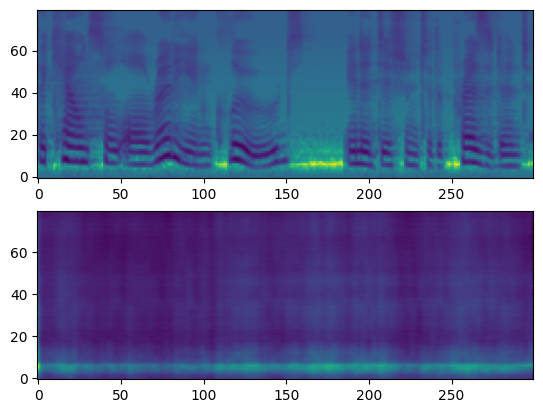

In [4]:


dataset_path = "../HiFiGAN-for-JAX/dataset/mels"

mel_file_paths = os.listdir(dataset_path)

def truncate_and_pad(audio: jax.Array, width: int = 300):
    audio_length = audio.shape[1]
    
    target_length = int(width)
    if audio_length > target_length:
        audio = audio[:, :target_length]
    else:
        audio = jnp.pad(audio, ((0, 0), (0, max(0, target_length - audio_length))))
    return audio

def get_batch(idx: list):
    batch = []
    for id in idx:
        array = jax.numpy.load(os.path.join(dataset_path, mel_file_paths[id]))[0]
        padded = truncate_and_pad(array)
        batch.append(padded)
    return jax.numpy.array(batch)
        
key = jax.random.PRNGKey(69)

key1, key2 = jax.random.split(key, 2)

model = VQVAE(key=key1)
print(model.quantizer.codebook.shape)

model = eqx.tree_deserialise_leaves("../../XTTSv2-Finetuning-for-New-Languages/xttsvqvae.eqx", model)
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 32
fig, (ax1, ax2) = plt.subplots(2)
fig.show()

for epoch in range(epochs):
    key, grab = jax.random.split(key, 2)
    perm = jax.random.permutation(grab, len(mel_file_paths))
    eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)

    for i in range(0, len(mel_file_paths), batch_size):
        key, grab = jax.random.split(key, 2)
        batch_ids = perm[i: i + batch_size]
        batch = get_batch(batch_ids)

        model, opt_state, total_loss, reconstruct_loss, commit_loss, codebook_updates, y = make_step(model, optimizer, opt_state, batch, grab)

        step = epoch * len(mel_file_paths) + i
        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/Total', total_loss, step)
        writer.add_scalar('Loss/Reconstruct', reconstruct_loss, step)
        writer.add_scalar('Loss/Commit', commit_loss, step)
        
        writer.add_histogram('Codebook Updates/Code ids used', jnp.reshape(codebook_updates[1], -1), step)
        writer.add_histogram('Codebook Updates/Code means', jnp.mean(codebook_updates[0][2], axis=(0,2)), step)
        writer.add_histogram('Codebook Updates/Code stds', jnp.std(codebook_updates[0][2], axis=(0,2)), step)
        if (i // batch_size) % 20 == 0:
            print(batch.shape)
            print(y.shape)
            ax1.clear()
            ax2.clear()
            ax1.imshow(batch[0], aspect='auto', origin='lower')
            ax2.imshow(y[0], aspect='auto', origin='lower')
            display(fig)
            clear_output(wait=True)
    # plt.imshow(y[0])


With a little bit of patience, we can see the output image start to resemble more and more the input one ! 

![Result after just 10 minutes of training on a NVIDIA L40](assets/result.png)

In the tensorboard we can also see that the codewords are progressively all used by the same amount during training. It's beautiful 🥰

![Codebooks slowly all being used uniformily.](<assets/uniform.png>)

This concludes this chapter, if you have any questions or remarks feel free to reach out to me ! @sxyBoi on Telegram 😅

---
nocite: |
  @*
---

# References